In [1]:
git_repo = '../../..'

import sys
import os

sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib

# Local libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib

import matplotlib.pyplot as plt
%matplotlib inline

from copy import deepcopy

from autograd import numpy as np
from autograd import scipy as sp

# import numpy as np
# import scipy as sp

np.random.seed(453453)

import json 

In [2]:
# Load results from previous fit.
json_input_file = os.path.join(
    git_repo, 'BNP_sensitivity/GMM_clustering/iris_fits/ryan_iris_bnp_full_data_fit.json')

with open(json_input_file, 'r') as fp:
    fit_dict = json.load(fp)
    model = gmm_utils.get_model_from_checkpoint(fit_dict)
    model_ = gmm_utils.get_model_from_checkpoint(fit_dict)
    best_param = model.global_vb_params.get_free()
    kl_hessian = gmm_utils.get_kl_hessian_from_checkpoint(fit_dict)

In [3]:
moment_model = gmm_utils.InterestingMoments(model)
dg_deta = moment_model.get_moment_jacobian(best_param)
linear_sens = gmm_utils.LinearSensitivity(model, moment_model, kl_hessian)

Prior Hessian...
Data Hessian...
Linear systems...
Done.


In [4]:
model_refit = deepcopy(model)
print(model.prior_params)

prior_params:
	alpha: [8.]
	prior_centroid_mean: [0.]
	prior_centroid_info: [0.1]
	prior_gamma_df: [8.]
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]


In [5]:
print(model.vb_params)

vb_params:
	global:
	centroids:
[[ 0.38617564 -0.83707585 -0.76185291  0.26421756  0.1909615   0.16448917
   0.14318343  0.12300122  0.10298026  0.08295275  0.06321091  0.56583563]
 [-0.23785197  0.36417569 -0.46894246 -0.36303748 -0.25618245 -0.24357091
  -0.2379739  -0.23515696 -0.23406846 -0.23424279 -0.23536002 -0.03444726]
 [ 0.93705262 -2.29444971  0.70414719  1.48993457  1.07430602  1.00040892
   0.95295475  0.91453312  0.88084611  0.85032012  0.82243997  1.63479319]
 [ 0.28261006 -0.95459405  0.43055354  0.37979753  0.39397773  0.37489534
   0.35972444  0.34609326  0.33334613  0.32128388  0.30992882  0.92767109]]
	v_sticks:
	mean:
[-0.33605921  0.18057417 -3.28796636 -3.29534063 -3.50801316 -3.53888155
 -3.56094937 -3.57947803 -3.59580754 -3.61049026 -3.62379409]
	info:
[38.42048807 22.98154803  1.83852021  1.79353795  1.50905486  1.45821925
  1.41949997  1.38639102  1.35707926  1.33072428  1.30684704]
	gamma:
[[[ 9.75587106e+00 -3.30728257e+00 -7.09721750e+00  1.90987686e+00]


In [6]:
import functional_sensitivity_lib as fun_sens_lib
stick_sens = fun_sens_lib.StickSensitivity(model, best_param, kl_hessian, dg_deta.T)

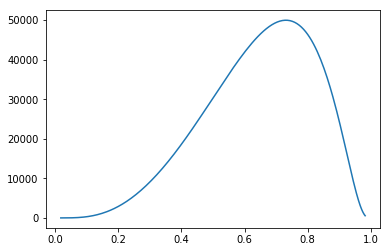

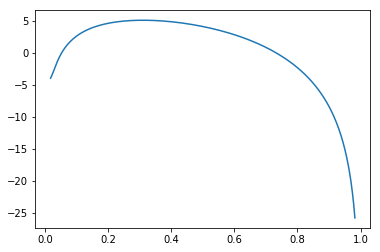

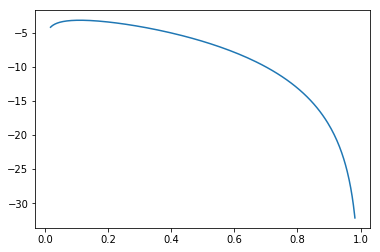

In [7]:

phi_center = 1
phi_log_rescale = stick_sens.get_log_p0_logit_stick(phi_center)
def phi(logit_v):
    return(np.exp(-0.5 * (logit_v - phi_center) ** 2 - phi_log_rescale))
logit_v_grid = np.linspace(-4, 4, 200)
v_grid = np.exp(logit_v_grid) / (1 + np.exp(logit_v_grid))

plt.plot(v_grid, phi(logit_v_grid))
plt.figure()
plt.plot(v_grid, stick_sens.get_log_p0_logit_stick(logit_v_grid) + np.log(1 + phi(logit_v_grid)))

plt.figure()
plt.plot(v_grid, stick_sens.get_log_p0_logit_stick(logit_v_grid))

In [8]:
import LinearResponseVariationalBayes.ExponentialFamilies as ef
vb_params = deepcopy(model.vb_params)

# Choose the number of GH points.
perturbed_log_density = lambda x : np.log(1.0 + phi(x))

expected_perturbations_list = []
gh_deg_list = np.arange(3, 100, 1)
for gh_deg in gh_deg_list:
    gmm_utils.set_gauss_hermite_points(vb_params, gh_deg=gh_deg)
    expected_perturbations_list.append(
        gmm_utils.get_e_log_perturbation_vec(vb_params, phi))

expected_perturbations_list = np.array(expected_perturbations_list)
#print(expected_perturbations_list.shape)
diffs = (expected_perturbations_list[1:, :] - \
         expected_perturbations_list[:-1, :]) / np.abs(expected_perturbations_list[1:, :] + 1e-6)
#print(np.max(diffs, axis=1))
gh_deg = np.argmax(np.max(diffs, axis=1) < 1e-5)

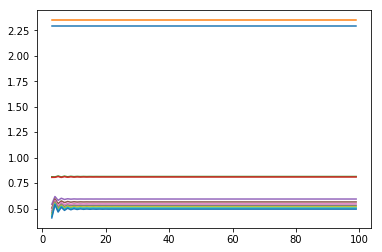

In [9]:
plt.plot(gh_deg_list, np.log(expected_perturbations_list))

In [10]:
import time
model_refit = deepcopy(model)
gmm_utils.set_gauss_hermite_points(model_refit.vb_params, gh_deg=gh_deg)

# First fit with no perturbation but the increased number of gh points.
model_refit.phi = None
best_param_0, kl_hessian, kl_hessian_corrected, \
init_opt_time, newton_time, x_conv, f_conv, vb_opt = \
model_refit.optimize_full(best_param,
    init_max_iter=100,
    final_max_iter=500)

print('Done. ')

BGFS
Iter: 0	 RMSE: 11.25532588213501	 Objective: -305.35768732642464
Optimization terminated successfully.
         Current function value: -305.357687
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Conditioned Newton:
i =  0
Optimization terminated successfully.
         Current function value: -305.357687
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 3.16425133715199e-05, f_diff = 1.7053025658242404e-12
Done. 


In [ ]:
# Then fit with the perturbation.
model_refit.phi = phi
best_param_phi, kl_hessian_phi, kl_hessian_corrected_phi, \
init_opt_time, newton_time, x_conv, f_conv, vb_opt = \
model_refit.optimize_full(best_param,
    init_max_iter=100,
    final_max_iter=500)

print('Done. ')